In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
import numpy as np

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

# device = torch.device("cpu")
print(device.type)

# ---

torch.manual_seed(42)
np.random.seed(42)

cpu


In [3]:
path_prefix = "2/"

In [4]:
class LWCNMP(nn.Module):
    def __init__(self, in_shape):
        super(LWCNMP, self).__init__()
        
        d_x, d_y = in_shape[0], in_shape[1]
        
        self.encoder = nn.Sequential(
            nn.Linear(d_x+d_y, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256)
#             nn.ReLU(),
#             nn.Linear(256, 256)
        )
        
        self.query = nn.Sequential(
            nn.Linear(256+d_x, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
#             nn.ReLU(),
#             nn.Linear(256, 256),
#             nn.ReLU(),
#             nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, d_y*2*2)
        )

    def forward(self, observations, target):
        # 2 sets of observations are given
        # for each set, n < n_max observations are fed to an encoder
        r0 = self.encoder(observations[0])
        r1 = self.encoder(observations[1])
        
        r_avg0 = torch.mean(r0, dim=0)
        r_avg1 = torch.mean(r1, dim=0)
        w = torch.rand(1).to(device)
        r_avg = r_avg0 * w + r_avg1 * (1-w)
        
        r_avgs = r_avg.repeat(target.shape[0], 1).to(device)  # repeating the same r_avg for each target
        
        r_avg_target = torch.cat((r_avgs, target), 1)
        query_out = self.query(r_avg_target)
        
        return query_out
    
#     def forward_gen(self, observations, target):
#         r0 = self.encoder(observations[0])
#         r1 = self.encoder(observations[1])
        
#         r_avg0 = torch.mean(r0, dim=0)
#         r_avg1 = torch.mean(r1, dim=0)
#         w = torch.rand(1).to(device)
#         r_avg = r_avg0 * w + r_avg1 * (1-w)
        
#         r_avgs = r_avg.repeat(target.shape[0], 1).to(device)  # repeating the same r_avg for each target
        
#         r_avg_target = torch.cat((r_avgs, target), 1)
#         query_out = self.query(r_avg_target)
        
#         return query_out


def log_prob_loss(output, target):
    mean, sigma = output.chunk(2, dim = -1)
    sigma = F.softplus(sigma)
    dist = D.Independent(D.Normal(loc=mean, scale=sigma), 1)
    return -torch.mean(dist.log_prob(target))

def log_prob_loss_mul(output, target):
    m0, sig0, m1, sig1 = output.chunk(4, dim = -1)
    
    sig0, sig1 = F.softplus(sig0), F.softplus(sig1)
    dist0, dist1 = D.Independent(D.Normal(loc=m0, scale=sig0), 1), D.Independent(D.Normal(loc=m1, scale=sig1), 1)
    return max(-torch.mean(dist0.log_prob(target)), -torch.mean(dist1.log_prob(target)))

# def log_prob_loss_mvn(output, target):
#     m0, sig0, m1, sig1 = output.chunk(4, dim = -1)
#     sig0, sig1 = F.softplus(sig0), F.softplus(sig1)
#     cov = torch.tensor([sig0**2, sig1**2])
#     dist = D.multivariate_normal.MultivariateNormal(loc=torch.tensor([m0, m1]), covariance_matrix=torch.diag(cov))
#     return -torch.mean(dist.log_prob(target.repeat(1,2).view(2)))

torch.Size([40, 200, 1])
torch.Size([40, 200, 1])
torch.Size([10, 200, 1])
torch.Size([10, 200, 1])


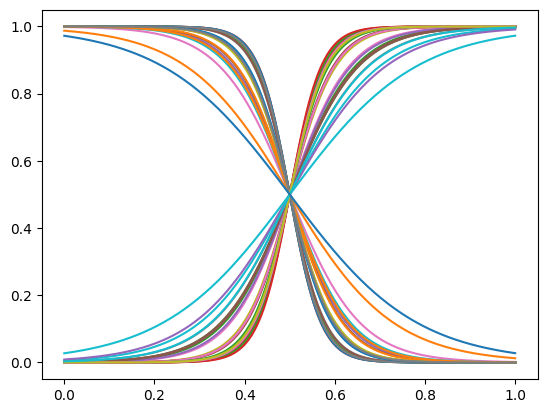

In [5]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def plot(data):
    x = torch.linspace(0, 1, data.shape[1])
    for traj in data:
        plt.plot(x, traj)

def cx_sigm(n=10, t_max=200):
    # rand_btw_7-30 * {-1, 1}
    c1 = (torch.rand(n, 1) * 23 + 7) * torch.from_numpy(np.random.choice([-1, 1], (n, 1)))  # c1 for steepness
    t = torch.linspace(0, 1, t_max)
    c2 = 0.5  # c2 midpoint
    
    data = 1/(1 + torch.exp(-c1 * (t-c2)))
    return data


n = 51
t_max = 200

data = cx_sigm(n, t_max).view(n, t_max, 1).to(device)
y_test = data[-1]

x_train, x_val, y_train, y_val = train_test_split(torch.linspace(0, 1, t_max).repeat(n-1, 1).
                                                  view(n-1, t_max, 1).to(device), data[:-1], train_size=0.8)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

plot(data.cpu())

In [6]:
n_max = 10
num_trajs, t_steps = x_train.shape[0], x_train.shape[1]
d_x, d_y = x_train.shape[-1], y_train.shape[-1]

model = LWCNMP((d_x, d_y)).to(device)
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def predict_model(observations, x_target, plot=True, step=-1, val_id=-1):    
    with torch.no_grad():
        prediction = model(observations, x_target)
        
#     y_pred = prediction[:, :d_y]
#     std_pred = torch.log(1+torch.exp(prediction[:, d_y:]))

    # TODO: make this parametric
    y_pred0 = torch.unsqueeze(prediction[:, 0], 1)
    std_pred0 = torch.log(1+torch.exp(torch.unsqueeze(prediction[:, 1], 1)))

    y_pred1 = torch.unsqueeze(prediction[:, 2], 1)
    std_pred1 = torch.log(1+torch.exp(torch.unsqueeze(prediction[:, 3], 1)))
    
    if plot:
        for i in range(d_y):  # for every feature in Y vector we are plotting training data and its prediction
            fig = plt.figure(figsize=(5,5))
            plt.plot(x_val[val_id, :, 0].cpu(), y_val[val_id, :, i].cpu())

            plt.plot(x_val[val_id, :, 0].cpu(), y_pred0[:, i].cpu(), color='black')
            plt.errorbar(x_val[val_id, :, 0].cpu(), y_pred0[:, i].cpu(), yerr=std_pred0[:, i].cpu(), color = 'black', alpha=0.4)
            
            plt.plot(x_val[val_id, :, 0].cpu(), y_pred1[:, i].cpu(), color='black')
            plt.errorbar(x_val[val_id, :, 0].cpu(), y_pred1[:, i].cpu(), yerr=std_pred1[:, i].cpu(), color = 'black', alpha=0.4)
            
            plt.scatter(observations[0, :, 0].cpu(), observations[0, :, d_x+i].cpu(), marker="X", color='black')
            plt.savefig(f'{path_prefix}{step}_{val_id}_val.png')
            plt.close()
    return y_pred, std_pred


def predict_model_val(observations, x_target, y_true, plot=True, step=-1, val_id=-1):    
    with torch.no_grad():
        prediction = model(observations, x_target)
        
#     y_pred = prediction[:, :d_y]
#     std_pred = torch.log(1+torch.exp(prediction[:, d_y:]))

    # TODO: make this parametric
    y_pred0 = torch.unsqueeze(prediction[:, 0], 1)
    std_pred0 = torch.log(1+torch.exp(torch.unsqueeze(prediction[:, 1], 1)))

    y_pred1 = torch.unsqueeze(prediction[:, 2], 1)
    std_pred1 = torch.log(1+torch.exp(torch.unsqueeze(prediction[:, 3], 1)))
    
    e0, e1 = torch.mean((y_pred0 - y_true)**2), torch.mean((y_pred1 - y_true)**2)
    if e0 < e1:
        y_pred = y_pred0
        std_pred = std_pred0
        y_other = y_pred1
        std_other = std_pred1
    else:
        y_pred = y_pred1
        std_pred = std_pred1
        y_other = y_pred0
        std_other = std_pred0
    
    if plot:
        for i in range(d_y):  # for every feature in Y vector we are plotting training data and its prediction
            fig = plt.figure(figsize=(5,5))
            plt.plot(x_val[val_id, :, 0].cpu(), y_val[val_id, :, i].cpu())

            plt.plot(x_val[val_id, :, 0].cpu(), y_pred[:, i].cpu(), color='red')
            plt.errorbar(x_val[val_id, :, 0].cpu(), y_pred[:, i].cpu(), yerr=std_pred[:, i].cpu(), color = 'red', alpha=0.4)
            
            plt.plot(x_val[val_id, :, 0].cpu(), y_other[:, i].cpu(), color='yellow', alpha=0.2)
            plt.errorbar(x_val[val_id, :, 0].cpu(), y_other[:, i].cpu(), yerr=std_other[:, i].cpu(), color = 'yellow', alpha=0.2)
            
            plt.scatter(observations[0, :, 0].cpu(), observations[0, :, d_x+i].cpu(), marker="X", color='black')
            plt.savefig(f'{path_prefix}{step}_{val_id}_val.png')
            plt.close()
    return y_pred, std_pred


def get_training_sample():
    n = torch.randint(1, n_max, (1,))
    traj0_id, traj1_id = np.random.choice(num_trajs, 1), np.random.choice(num_trajs, 1)  # pick 2 trajs
    obs0_steps, obs1_steps = torch.randperm(t_steps)[:n+1], torch.randperm(t_steps)[:n+1]  # pick n points from each

    observations = torch.zeros(2, n, d_x+d_y, device=device)
    x_target = torch.zeros(1, 1, d_x, device=device)
    y_target = torch.zeros(1, 1, d_y, device=device)
    
    observations[0] = torch.hstack((x_train[traj0_id, obs0_steps[:-1], :], y_train[traj0_id, obs0_steps[:-1], :]))
    observations[1] = torch.hstack((x_train[traj1_id, obs1_steps[:-1], :], y_train[traj1_id, obs1_steps[:-1], :]))

    if torch.rand(1) < 0.5:
        x_target = x_train[traj0_id, obs0_steps[-1], :]
        y_target = y_train[traj0_id, obs0_steps[-1], :]
    else:
        x_target = x_train[traj1_id, obs1_steps[-1], :]
        y_target = y_train[traj1_id, obs1_steps[-1], :]

    return observations, x_target, y_target

In [7]:
smooth_losses = [0]
losses = []
loss_checkpoint = 1000
loss_inform_checkpoint = 10000
plot_checkpoint = 50000
validation_checkpoint = 1000
validation_error = 9999999
min_loss = 100

val_observation = torch.zeros(2, 1, d_x+d_y, device=device)
nof_val_trajs = x_val.shape[0]

for step in range(50000000):
    observations, target_t, target_output = get_training_sample()
    
    optimizer.zero_grad()
    output = model(observations, target_t)
    loss = log_prob_loss_mul(output, target_output)
    loss.backward()
    optimizer.step()
    
    if loss.data < min_loss:
        min_loss = loss
        print(f'Loss: {loss.data}')
    
    if step % loss_inform_checkpoint == 0:
        print(f'Step: {step} ')
    
    if step % loss_checkpoint == 0:
        losses.append(loss.data.cpu())
        smooth_losses[-1] += loss.data.cpu()/(plot_checkpoint/loss_checkpoint)
    
    if step % validation_checkpoint == 0:
        current_error = 0
        val_traj_ids = np.random.permutation(nof_val_trajs)  # changing validation order, shouldn't make a diff
        for i in val_traj_ids:
            val_observation[0] = val_observation[1] = torch.cat((x_val[i, 0], y_val[i, 0]))
            y_pred, std_pred = predict_model_val(val_observation, x_val[i], y_val[i], plot=False, step=-1)
            current_error += torch.mean((y_pred - y_val[i, :])**2) / nof_val_trajs
        if current_error < validation_error:
            validation_error = current_error
            torch.save(model.state_dict(), f'{path_prefix}cnmp_best_validation.h5')
            if not step % plot_checkpoint == 0:
                print(f'Step: {step}. New validation best. Error: {current_error}')
            else:
                print(f'Step: {step}. New validation best.', end=' ')
        
    if step % plot_checkpoint == 0:
        print(f'Plotting... Error: {current_error}')
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.title('Train Loss')
        plt.plot(range(len(losses)),losses)
        plt.subplot(122)
        plt.title('Train Loss (Smoothed)')
        plt.plot(range(len(smooth_losses)), smooth_losses)
        plt.savefig(f'{path_prefix}{step}.png')
        plt.close()
        
        val_traj_ids = np.random.permutation(nof_val_trajs)  # changing validation order, shouldn't make a diff
        #plotting validation cases
        for i in val_traj_ids:
            val_observation[0] = val_observation[1] = torch.cat((x_val[i, 0], y_val[i, 0]))
            predict_model_val(val_observation, x_val[i], y_val[i], plot=True, step=step, val_id=i)
        
        if step!=0:
            smooth_losses.append(0)
# print('Finished Training')

Loss: 1.5088765621185303
Step: 0 


RuntimeError: Parent directory 2 does not exist.

In [ ]:
model = LWCNMP((d_x, d_y)).to(device)
model.load_state_dict(torch.load(f'{path_prefix}cnmp_best_validation.h5'))

test_observation = torch.zeros(2, 2, d_x+d_y, device=device)
test_observation[0] = test_observation[1] = torch.hstack((torch.Tensor([[0.], [1]]).to(device), torch.Tensor([[1], [1]]).to(device)))
# test_observation = torch.zeros(1, 1, d_x+d_y, device=device)
# test_observation[0] = torch.cat((torch.Tensor([0.5]).to(device), torch.Tensor([0.5]).to(device)))
p, s = predict_model_val(test_observation, x_val[0], y_val[0], plot=True, step=-2)